In [1]:
!pip install -Uqq fastai icrawler

In [2]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

In [3]:
def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

In [4]:
search_images("grizzly bear", 1)

Searching for 'grizzly bear'


In [40]:
from fastai.vision.all import *

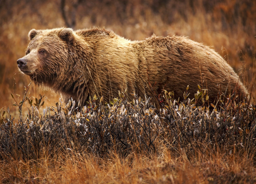

In [7]:
im = Image.open("grizzly bear000001.png")
im.to_thumb(256,256)

In [11]:
no_of_photos = 100

bear_types = 'grizzly','black','teddy'
path = Path('bears')

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        search_images(f"{o} bear", no_of_photos, dest)
        print(f"Photos of {o} bear downloaded!")

Searching for 'grizzly bear'
Photos of grizzly bear downloaded!
Searching for 'black bear'
Photos of black bear downloaded!
Searching for 'teddy bear'
Photos of teddy bear downloaded!


In [25]:
fns = get_image_files(path)
fns

(#167) [Path('bears/grizzly/grizzly bear000013.png'),Path('bears/grizzly/grizzly bear000020.png'),Path('bears/grizzly/grizzly bear000017.png'),Path('bears/grizzly/grizzly bear000028.png'),Path('bears/grizzly/grizzly bear000008.png'),Path('bears/grizzly/grizzly bear000022.png'),Path('bears/grizzly/grizzly bear000019.png'),Path('bears/grizzly/grizzly bear000004.png'),Path('bears/grizzly/grizzly bear000054.png'),Path('bears/grizzly/grizzly bear000023.png')...]

In [26]:
failed = verify_images(fns)
failed

(#0) []

In [27]:
failed.map(Path.unlink);

In [30]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

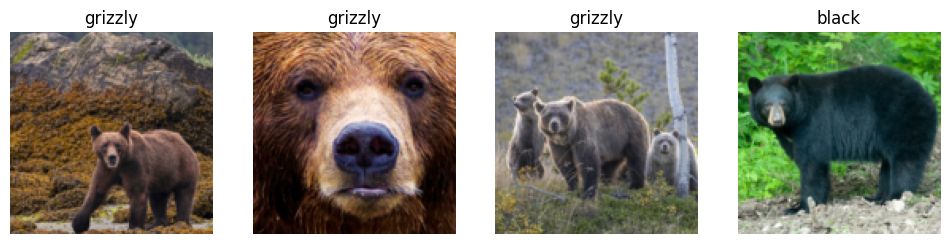

In [31]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [33]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

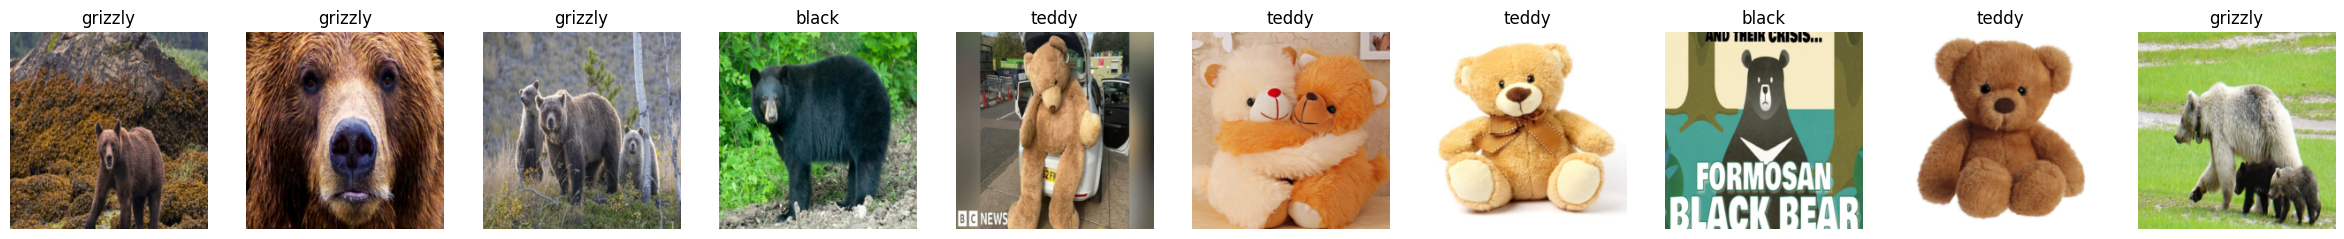

In [35]:
dls.valid.show_batch(max_n=10, nrows=1)

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.122489,1.432765,0.393939,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.860898,0.719034,0.212121,00:35
1,0.659852,0.244657,0.151515,00:36
2,0.482695,0.122827,0.060606,00:35
3,0.384022,0.113100,0.060606,00:35


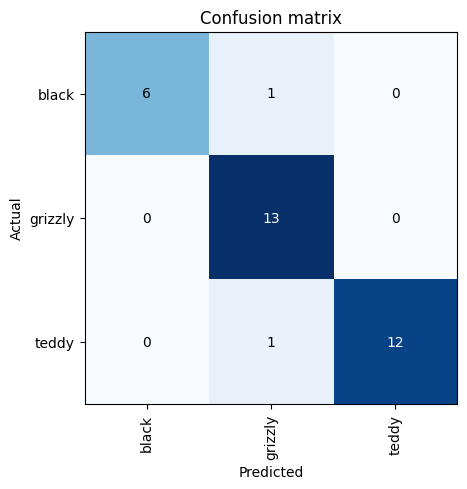

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

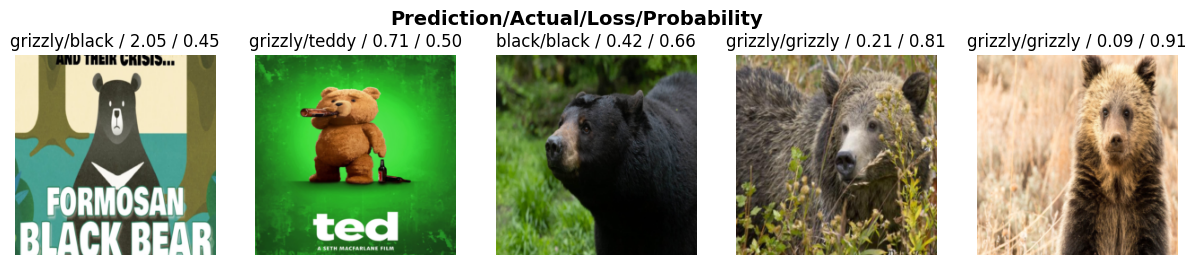

In [38]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner